In [ ]:
# Dataset Reference: https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/
# Imports
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier
from scipy.stats import uniform

<h3> --------------------------------- Milestone 1 --------------------------------- <h3>

<h4> --------------------------------- Exploratory Data Analysis (EDA) --------------------------------- <h4>

<h5>----- Loading the Dataset and displaying the first few rows -----<h5>

In [3]:


# Dataset Reads
details_df = pd.read_csv('StormEvents_details-ftp_v1.0_d2024_c20241017.csv')
fatalities_df = pd.read_csv('StormEvents_fatalities-ftp_v1.0_d2024_c20241017.csv') # not relevant
location_df = pd.read_csv('StormEvents_locations-ftp_v1.0_d2024_c20241017.csv')

# Merge datasets
merged_df = pd.merge(details_df, location_df, on = 'EVENT_ID', how = 'left')

# Displaying dataset head
display(merged_df.head())

,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID_x,EVENT_ID,STATE,STATE_FIPS,...,YEARMONTH,EPISODE_ID_y,LOCATION_INDEX,RANGE,AZIMUTH,LOCATION,LATITUDE,LONGITUDE,LAT2,LON2
0,202402,7,1728,202402,7,1745,187494,1151178,TEXAS,48,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,202402,8,804,202402,8,804,187655,1152279,WYOMING,56,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,202402,2,1621,202402,2,1621,187493,1151454,TEXAS,48,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,202402,14,1800,202402,16,1800,187699,1152478,WYOMING,56,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,202402,18,2218,202402,19,200,187728,1152830,WYOMING,56,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<h5>----- Analyzing data distributions for numerical features -----<h5>

In [4]:
# Displaying basic information
merged_df.info()

# Displaying statistical summary for numerical columns
merged_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65951 entries, 0 to 65950
Data columns (total 61 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   BEGIN_YEARMONTH     65951 non-null  int64  
 1   BEGIN_DAY           65951 non-null  int64  
 2   BEGIN_TIME          65951 non-null  int64  
 3   END_YEARMONTH       65951 non-null  int64  
 4   END_DAY             65951 non-null  int64  
 5   END_TIME            65951 non-null  int64  
 6   EPISODE_ID_x        65951 non-null  int64  
 7   EVENT_ID            65951 non-null  int64  
 8   STATE               65951 non-null  object 
 9   STATE_FIPS          65951 non-null  int64  
 10  YEAR                65951 non-null  int64  
 11  MONTH_NAME          65951 non-null  object 
 12  EVENT_TYPE          65951 non-null  object 
 13  CZ_TYPE             65951 non-null  object 
 14  CZ_FIPS             65951 non-null  int64  
 15  CZ_NAME             65951 non-null  object 
 16  WFO 

,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID_x,EVENT_ID,STATE_FIPS,YEAR,...,END_LAT,END_LON,YEARMONTH,EPISODE_ID_y,LOCATION_INDEX,RANGE,LATITUDE,LONGITUDE,LAT2,LON2
count,65951.000000,65951.000000,65951.000000,65951.000000,65951.000000,65951.000000,65951.000000,6.595100e+04,65951.000000,65951.0,...,47874.000000,47874.000000,41746.000000,41746.000000,41746.000000,41746.000000,41746.000000,41746.000000,4.174600e+04,4.174600e+04
mean,202404.486300,15.185729,1300.320859,202404.486300,16.223939,1436.807175,191046.240861,1.178641e+06,33.101818,2024.0,...,37.355362,-90.045996,202405.120347,191635.227591,1.810401,2.387486,37.457545,-89.499012,3.186746e+06,7.558354e+06
std,2.039658,8.784294,653.828558,2.039658,8.754396,631.410860,2223.421907,1.643105e+04,19.644899,0.0,...,5.697974,11.753810,1.717121,2023.797429,1.308168,4.046168,5.859095,11.922196,1.351090e+06,3.247219e+06
min,202401.000000,1.000000,0.000000,202401.000000,1.000000,0.000000,186811.000000,1.146596e+06,1.000000,2024.0,...,-14.340500,-170.825000,202401.000000,186883.000000,1.000000,0.000000,-14.344900,-170.829000,-1.420694e+06,-1.444804e+07
25%,202403.000000,8.000000,830.000000,202403.000000,9.000000,1000.000000,189213.000000,1.164944e+06,19.000000,2024.0,...,34.040050,-96.500000,202404.000000,190357.000000,1.000000,0.750000,34.389025,-96.080000,3.045015e+06,7.621600e+06
50%,202405.000000,15.000000,1445.000000,202405.000000,16.000000,1605.000000,191084.000000,1.179169e+06,31.000000,2024.0,...,38.020000,-90.054650,202405.000000,191829.000000,1.000000,1.460000,38.194850,-89.113450,3.655059e+06,8.548141e+06
75%,202406.000000,23.000000,1813.000000,202406.000000,24.000000,1905.000000,192748.000000,1.192388e+06,46.000000,2024.0,...,41.350000,-81.764000,202406.000000,193100.000000,2.000000,2.760000,41.550000,-81.294850,4.047400e+06,9.445600e+06
max,202407.000000,31.000000,2359.000000,202407.000000,31.000000,2359.000000,195655.000000,1.209484e+06,99.000000,2024.0,...,70.278900,144.800300,202407.000000,195645.000000,8.000000,172.190000,62.120000,144.800600,6.132604e+06,1.704974e+07


Index(['BEGIN_YEARMONTH', 'BEGIN_DAY', 'BEGIN_TIME', 'END_YEARMONTH',
       'END_DAY', 'END_TIME', 'EPISODE_ID_x', 'EVENT_ID', 'STATE_FIPS', 'YEAR',
       'CZ_FIPS', 'INJURIES_DIRECT', 'INJURIES_INDIRECT', 'DEATHS_DIRECT',
       'DEATHS_INDIRECT', 'MAGNITUDE', 'CATEGORY', 'TOR_LENGTH', 'TOR_WIDTH',
       'TOR_OTHER_CZ_FIPS', 'BEGIN_RANGE', 'END_RANGE', 'BEGIN_LAT',
       'BEGIN_LON', 'END_LAT', 'END_LON', 'YEARMONTH', 'EPISODE_ID_y',
       'LOCATION_INDEX', 'RANGE', 'LATITUDE', 'LONGITUDE', 'LAT2', 'LON2'],
      dtype='object')


/tmp/ipykernel_3606/4255739547.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize = (10, 3))


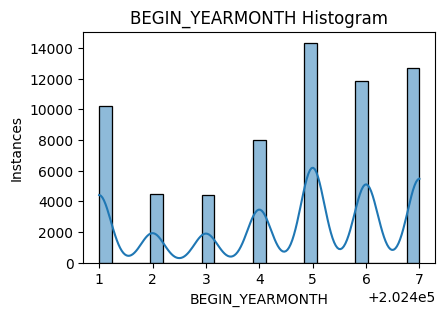

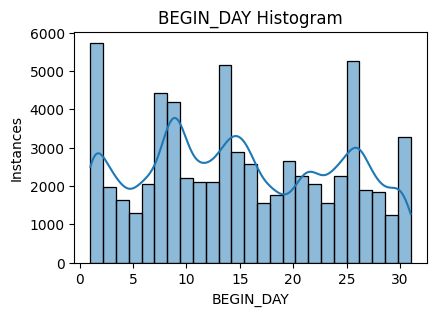

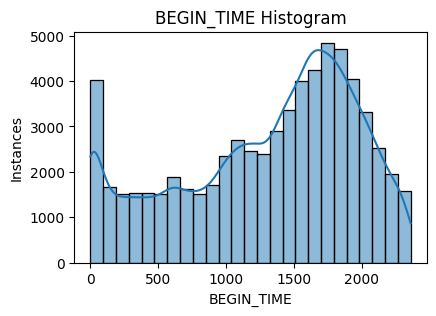

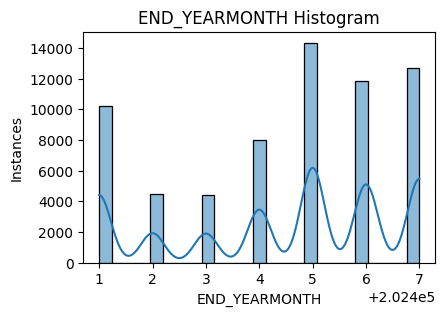

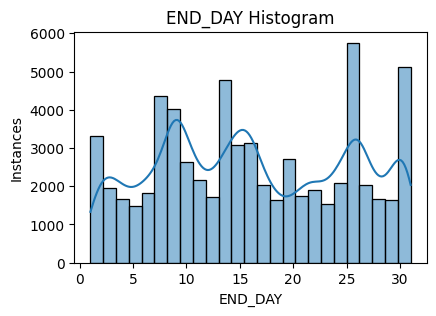

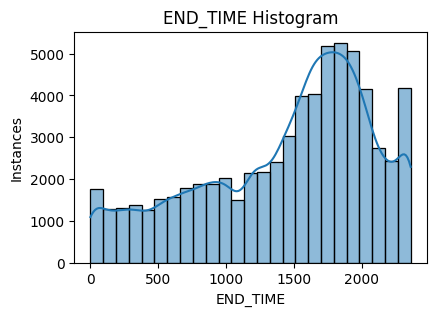

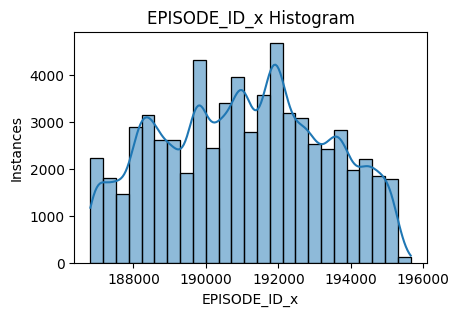

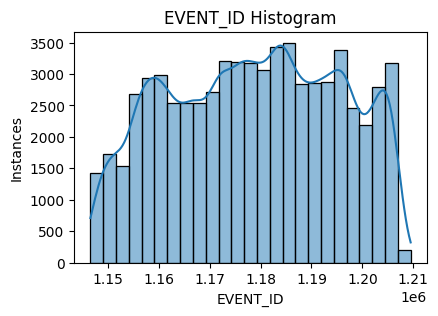

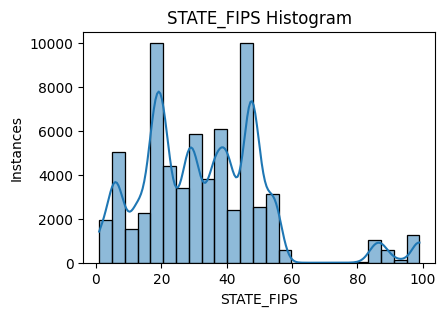

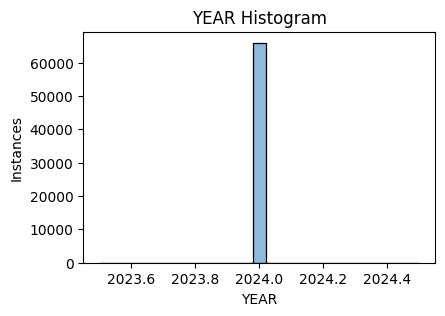

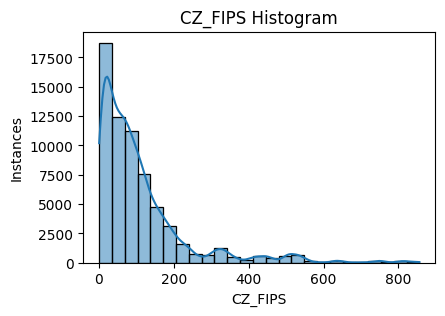

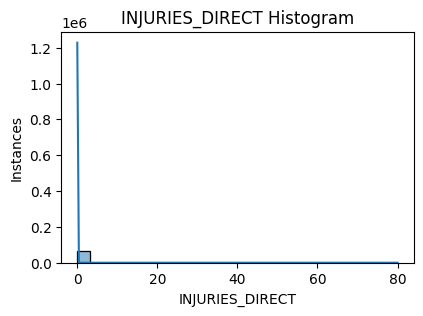

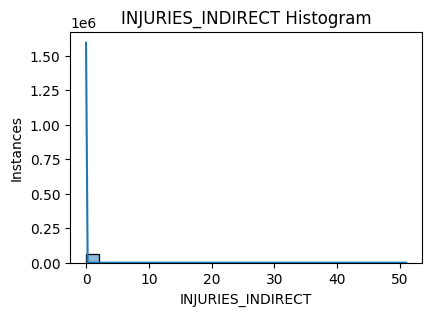

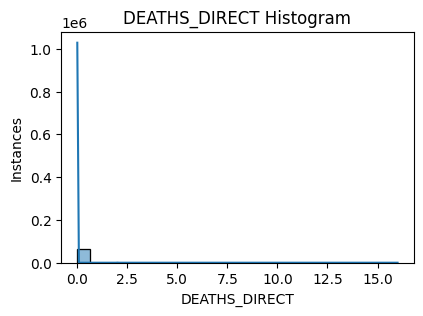

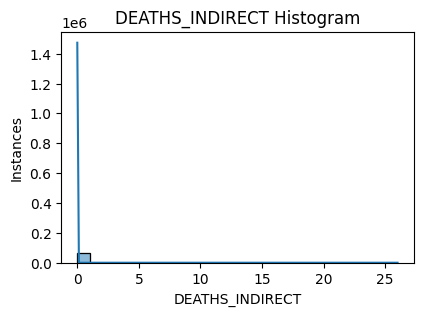

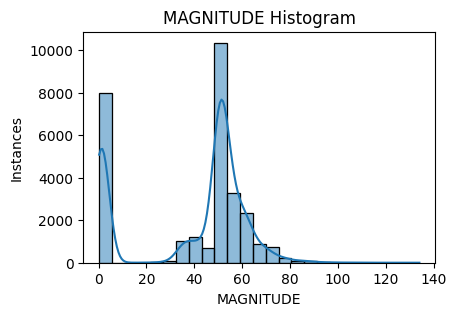

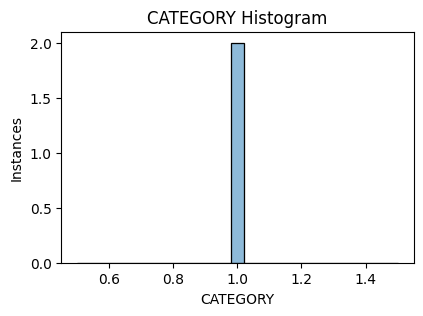

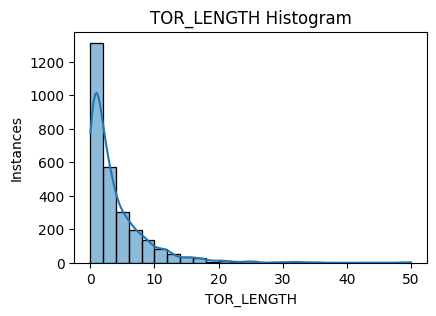

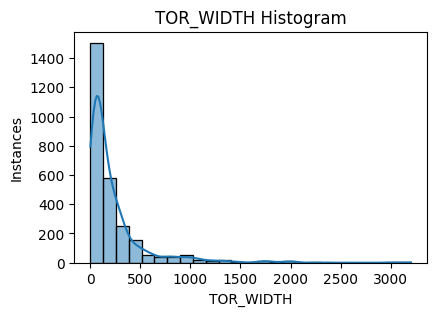

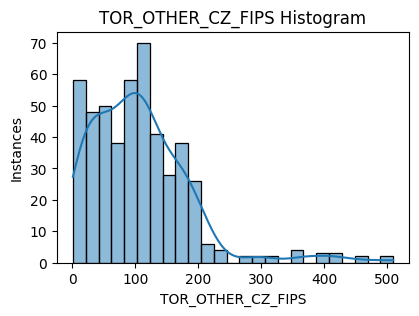

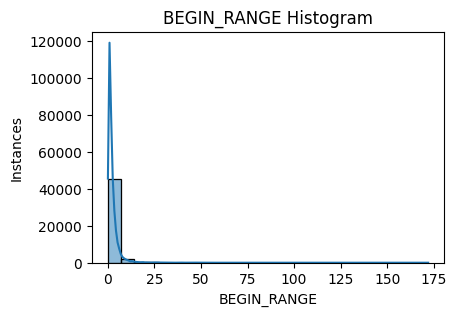

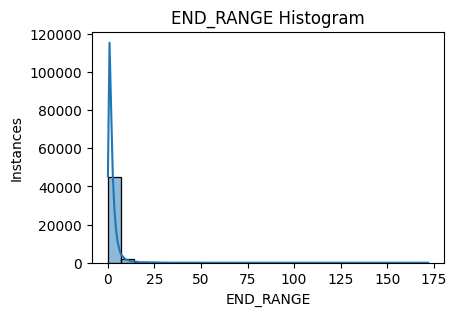

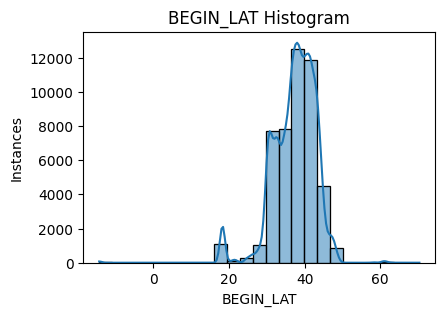

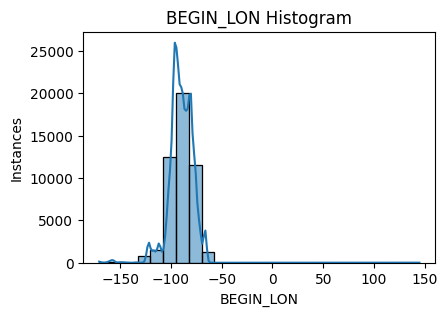

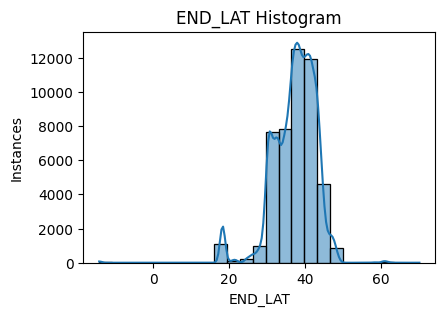

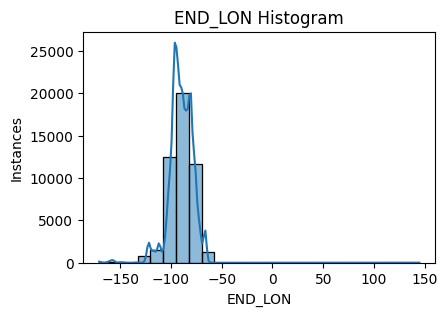

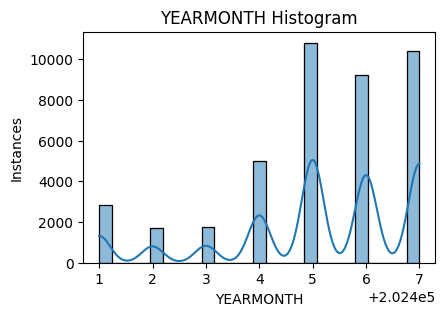

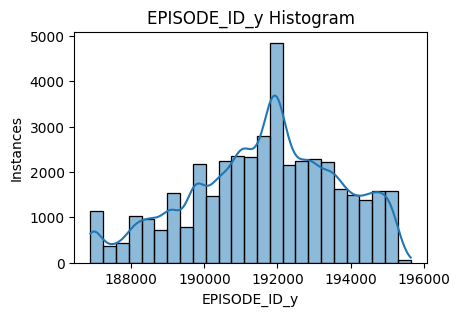

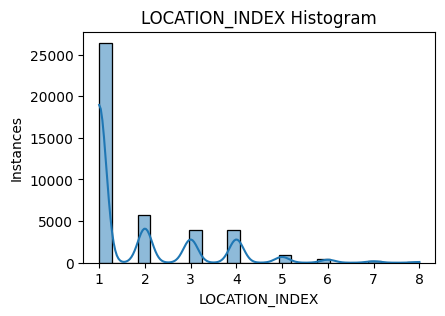

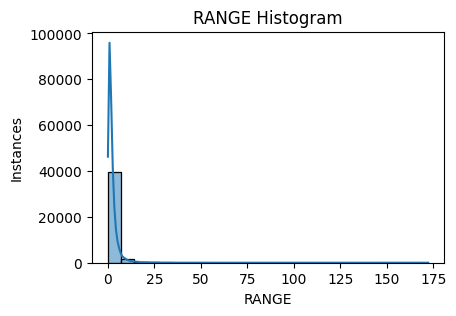

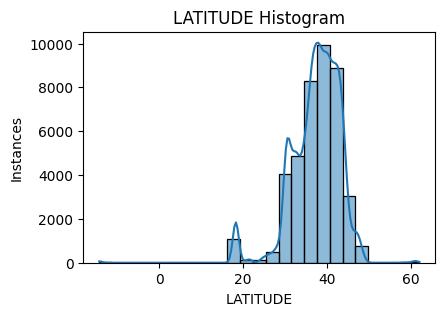

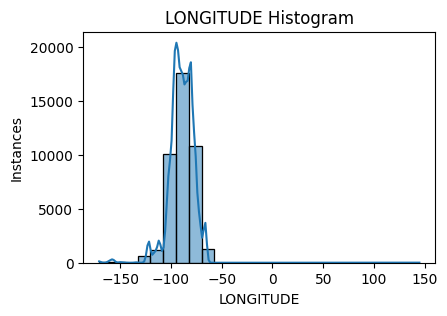

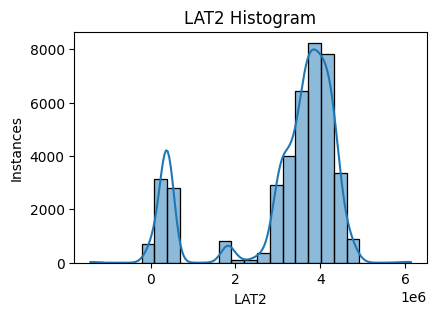

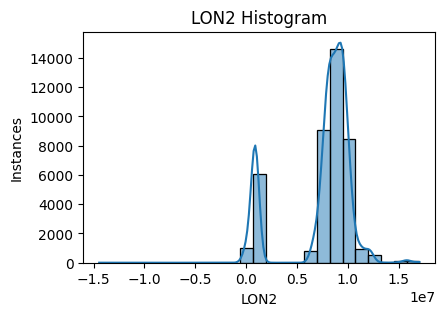

In [5]:
# Obtaining all numerical features
num_feats = merged_df.select_dtypes(include = [np.number]).columns
print(num_feats)

# Numerical Features Histograms
for feat in num_feats:
    plt.figure(figsize = (10, 3))
    plt.subplot(1, 2, 1)
    sns.histplot(merged_df[feat], kde = True, bins = 25)
    plt.title(f'{feat} Histogram')
    plt.xlabel(feat)
    plt.ylabel('Instances')



<h5>----- Visualizing relationships between variables -----<h5>

Text(0.5, 1.0, 'Numerical Features Correlation Matrix')

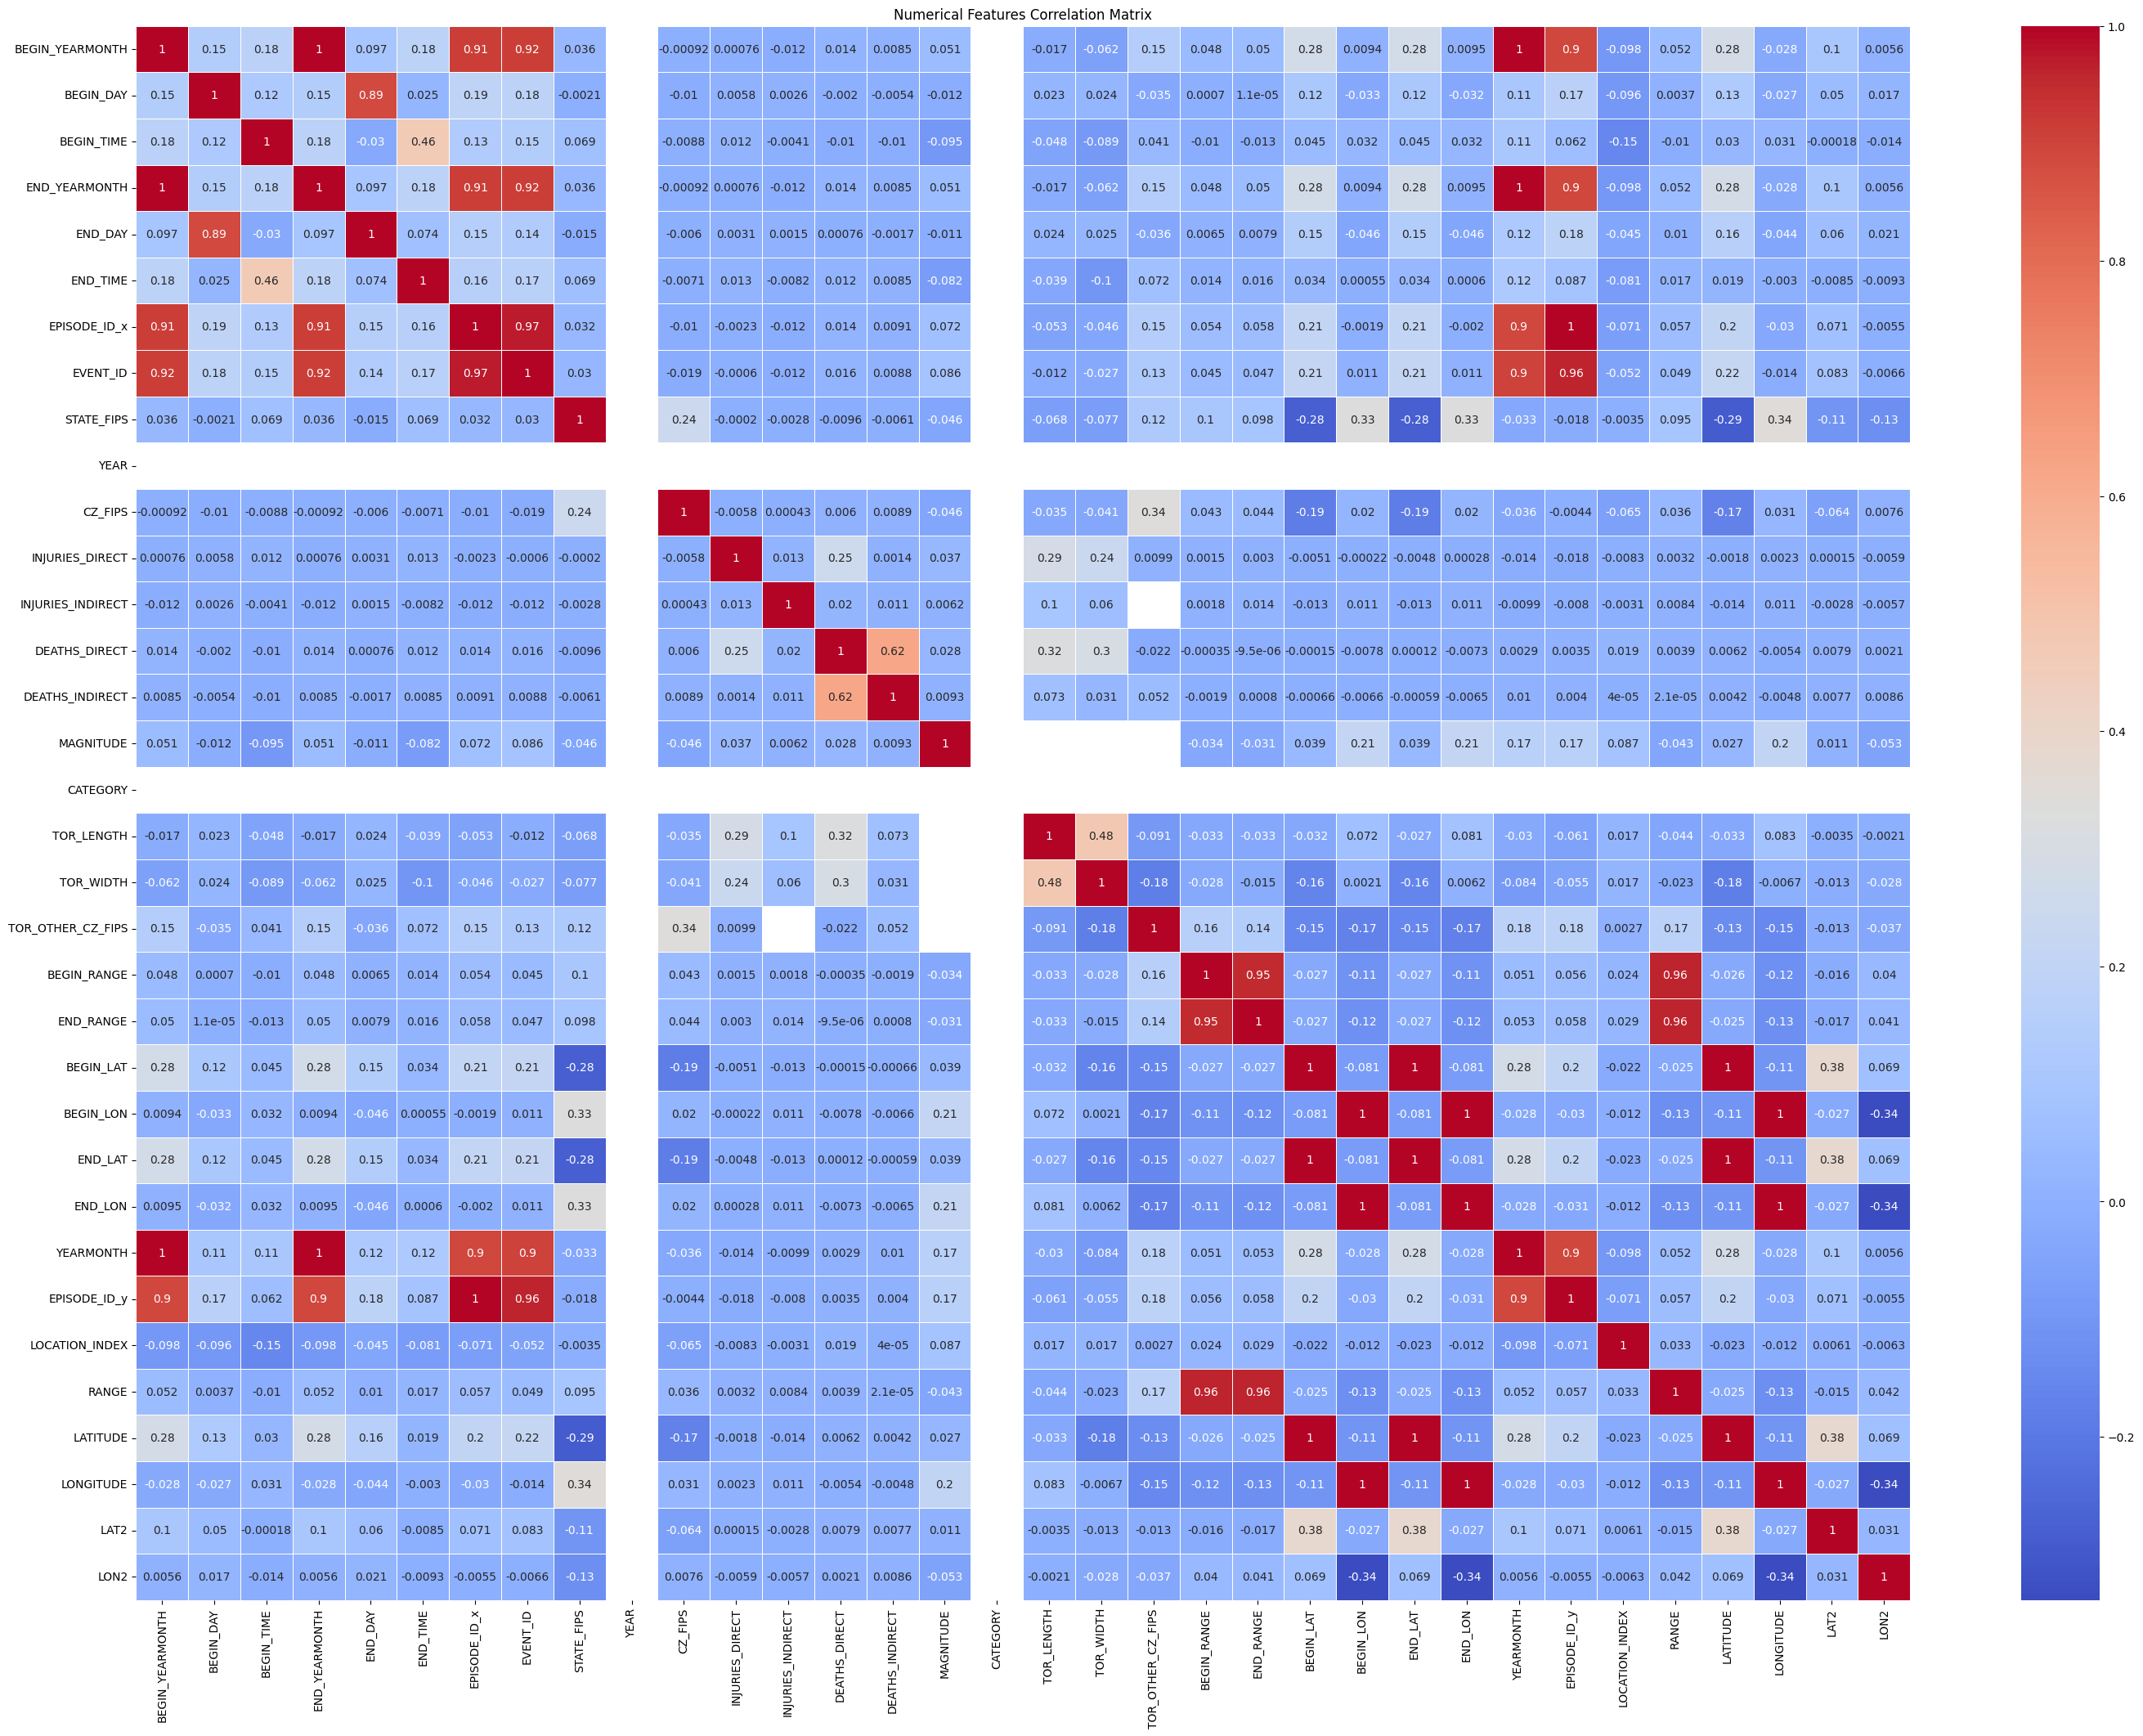

In [6]:
# Numerical Features Correlation Matrix
plt.figure(figsize = (35, 25))
sns.heatmap(merged_df[num_feats].corr(), annot =True, cmap = "coolwarm", linewidths = 0.65)
plt.title("Numerical Features Correlation Matrix")

<h5>----- Identifying any Outliers or Anomolies in the Data -----<h5>

/tmp/ipykernel_3606/3426957807.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize = (10, 3))


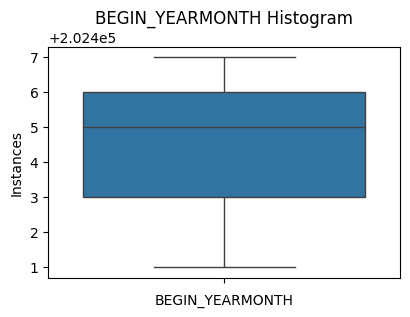

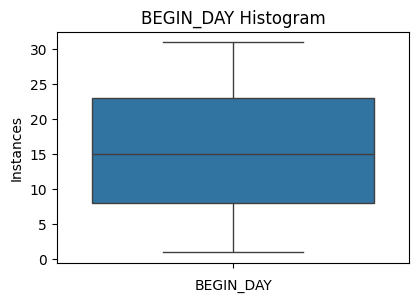

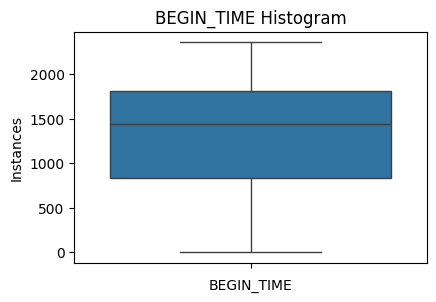

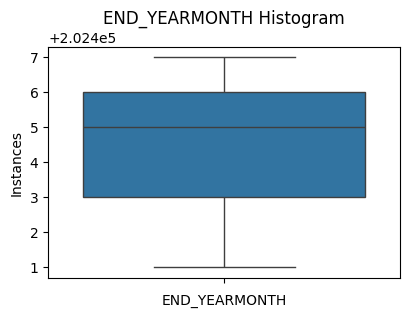

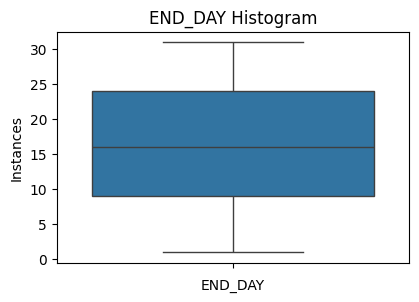

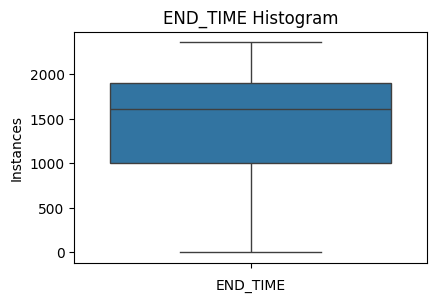

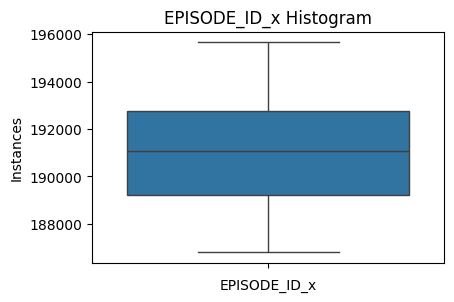

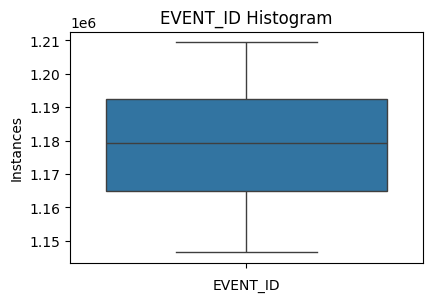

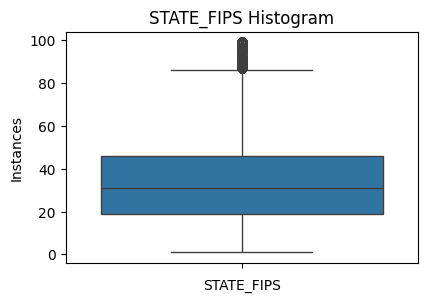

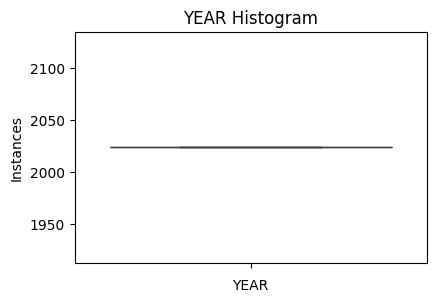

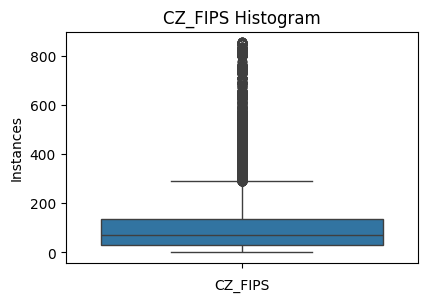

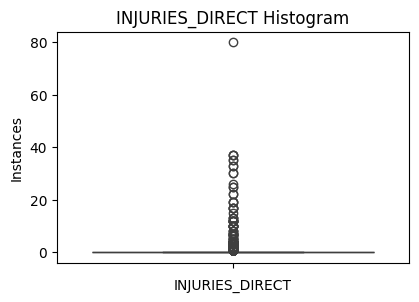

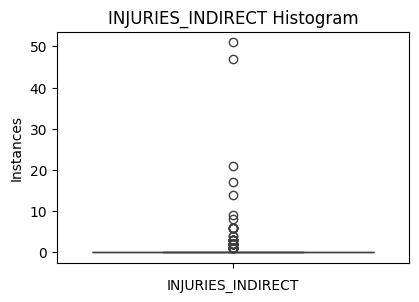

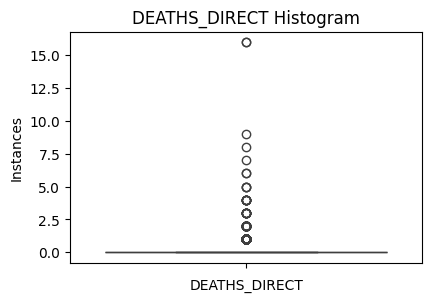

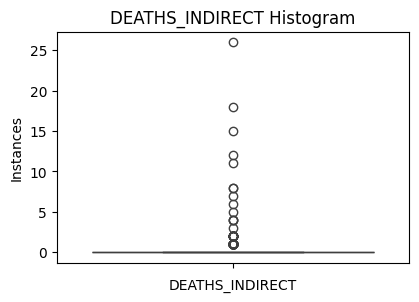

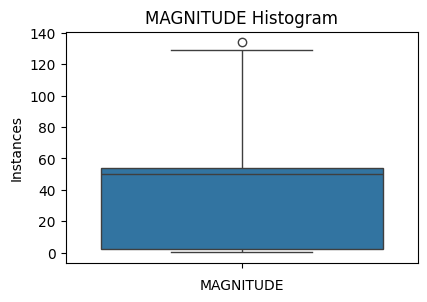

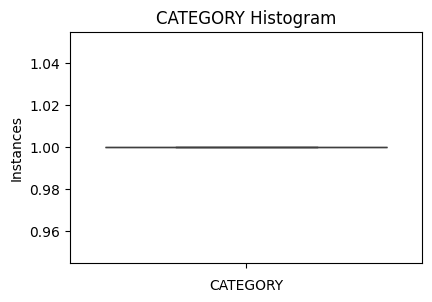

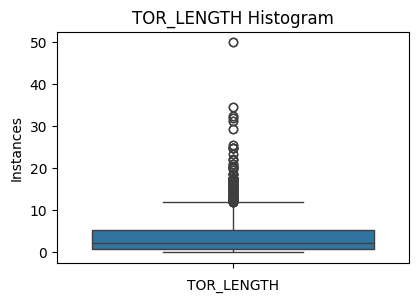

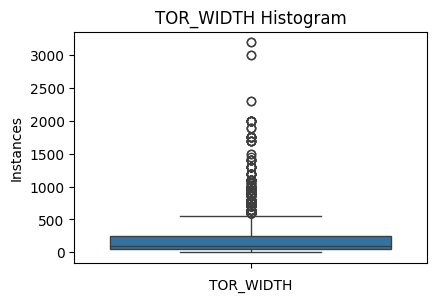

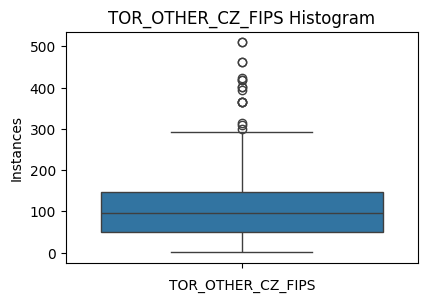

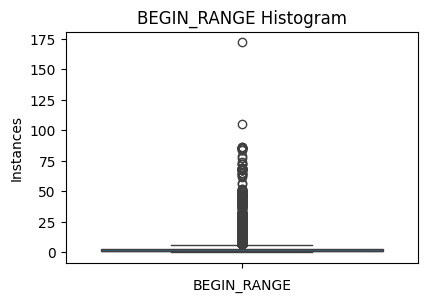

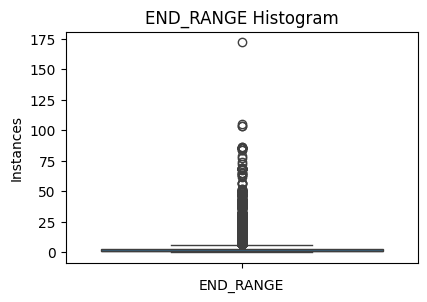

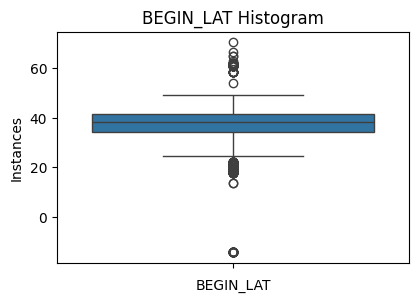

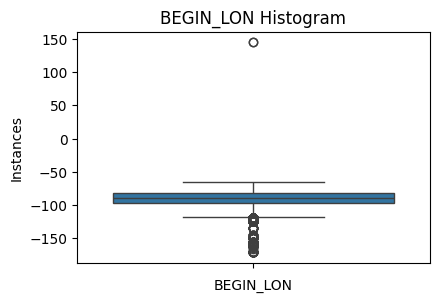

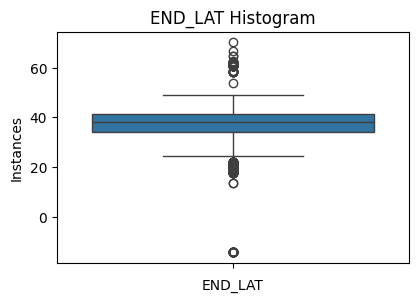

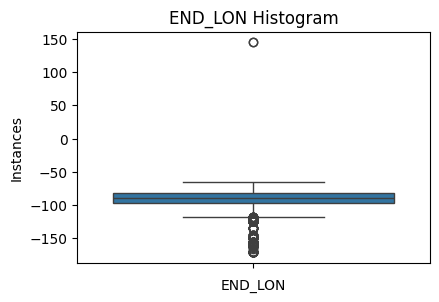

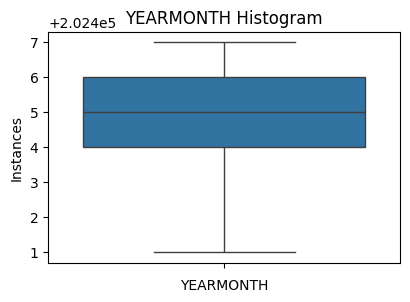

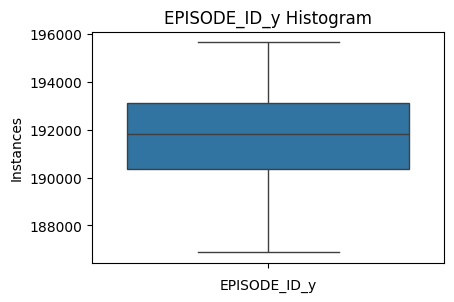

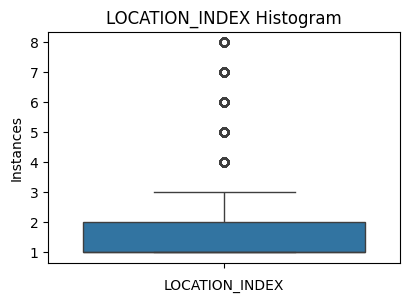

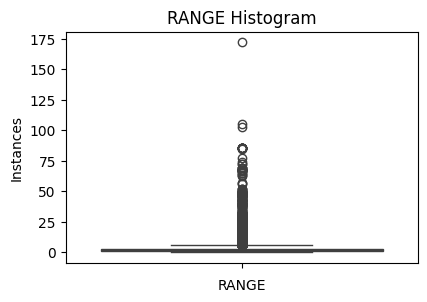

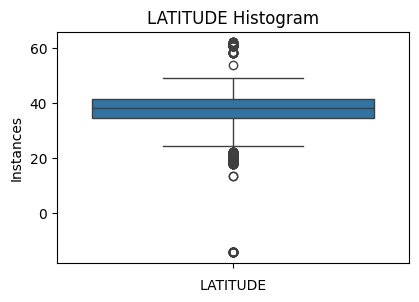

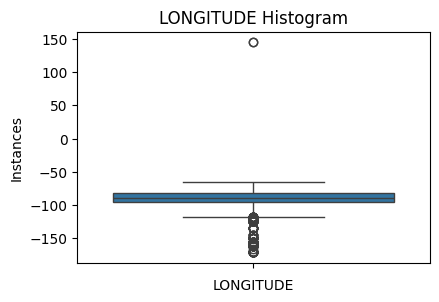

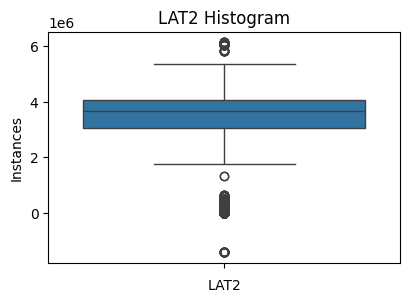

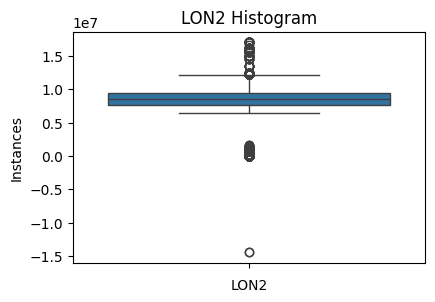

In [7]:
# Creating Box Plots for Numerical Features
for feat in num_feats:
    plt.figure(figsize = (10, 3))
    plt.subplot(1, 2, 1)
    sns.boxplot(merged_df[feat])
    plt.title(f'{feat} Histogram')
    plt.xlabel(feat)
    plt.ylabel('Instances')

<h4> --------------------------------- Data Cleaning --------------------------------- <h4>

<h5>----- Identifying and Handling Missing Values -----<h5>

In [8]:
# Printing all missing values in each column
missing_vals = merged_df.isnull().sum()
print("Missing Values within Dataset: ")
print(missing_vals[missing_vals > 0])

# Checking the skew of Numerical Features
for feat in num_feats:
    print(feat)
    print(merged_df[feat].skew())

# Median Imputation (Reasoning: To determine which imputation method i need to use 
# I first took the skews of all the numerical features with missing values. Since
# they all had slight skews, i have decided to proceed with median imputation.)
for feat in num_feats:
    if merged_df[feat].isnull().sum() > 0:
        merged_df[feat].fillna(merged_df[feat].median(), inplace = True)

# 
cat_feats = merged_df.select_dtypes(include=['object']).columns
for feat in cat_feats:
    if merged_df[feat].isnull().sum() > 0:
        merged_df[feat].fillna("Unknown", inplace=True)

Missing Values within Dataset: 
DAMAGE_PROPERTY       11309
DAMAGE_CROPS          11317
MAGNITUDE             36938
MAGNITUDE_TYPE        44938
FLOOD_CAUSE           47543
CATEGORY              65949
TOR_F_SCALE           63193
TOR_LENGTH            63193
TOR_WIDTH             63193
TOR_OTHER_WFO         65466
TOR_OTHER_CZ_STATE    65466
TOR_OTHER_CZ_FIPS     65466
TOR_OTHER_CZ_NAME     65466
BEGIN_RANGE           18077
BEGIN_AZIMUTH         18077
BEGIN_LOCATION        18077
END_RANGE             18077
END_AZIMUTH           18077
END_LOCATION          18077
BEGIN_LAT             18077
BEGIN_LON             18077
END_LAT               18077
END_LON               18077
EVENT_NARRATIVE        8725
YEARMONTH             24205
EPISODE_ID_y          24205
LOCATION_INDEX        24205
RANGE                 24205
AZIMUTH               24205
LOCATION              24205
LATITUDE              24205
LONGITUDE             24205
LAT2                  24205
LON2                  24205
dtype: int64
BEG

/tmp/ipykernel_3606/2017993929.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df[feat].fillna(merged_df[feat].median(), inplace = True)
/tmp/ipykernel_3606/2017993929.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, in

<h5>----- Standardizing data formats -----<h5>

In [9]:

# Converting Dates columns to the datetime format
merged_df['BEGIN_DATE_TIME'] = pd.to_datetime(merged_df['BEGIN_DATE_TIME'], errors = 'coerce')
merged_df['END_DATE_TIME'] = pd.to_datetime(merged_df['END_DATE_TIME'], errors = 'coerce')
print(merged_df['BEGIN_DATE_TIME'])


/tmp/ipykernel_3606/3680008504.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  merged_df['BEGIN_DATE_TIME'] = pd.to_datetime(merged_df['BEGIN_DATE_TIME'], errors = 'coerce')
/tmp/ipykernel_3606/3680008504.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  merged_df['END_DATE_TIME'] = pd.to_datetime(merged_df['END_DATE_TIME'], errors = 'coerce')


0       2024-02-07 17:28:00
1       2024-02-08 08:04:00
2       2024-02-02 16:21:00
3       2024-02-14 18:00:00
4       2024-02-18 22:18:00
                ...        
65946   2024-07-30 10:12:00
65947   2024-07-31 19:33:00
65948   2024-07-23 10:00:00
65949   2024-07-25 10:00:00
65950   2024-07-24 10:00:00
Name: BEGIN_DATE_TIME, Length: 65951, dtype: datetime64[ns]


<h5>----- Remove or address outliers identified in the EDA -----<h5>

In [10]:
# As I am planning to use a random forest model I am not going to remove any outliers

<h4> --------------------------------- Feature Engineering --------------------------------- <h4>

<h5>----- Create new features that could enhance the predictive power of your models -----<h5>


In [11]:
# Extracting date components
merged_df['BEGIN_YEAR'] = merged_df['BEGIN_YEARMONTH'] // 100
merged_df['BEGIN_MONTH'] = merged_df['BEGIN_YEARMONTH'] % 100
merged_df['BEGIN_HOUR'] = merged_df['BEGIN_TIME'] // 100
merged_df['END_YEAR'] = merged_df['END_YEARMONTH'] // 100
merged_df['END_MONTH'] = merged_df['END_YEARMONTH'] % 100
merged_df['END_HOUR'] = merged_df['END_TIME'] // 100

# Creating a feature that records the duration of an event instance and Handling potential negative durations
merged_df['EVENT_DURATION'] = merged_df['END_TIME'] - merged_df['BEGIN_TIME']
merged_df['EVENT_DURATION'] = merged_df['EVENT_DURATION'].apply(lambda x: x if x >= 0 else x + 2400)


<h5>----- Transform categorical variables into numerical ones using techniques like one-hot encoding. -----<h5>


In [12]:
# Removing unnecessary Features DUE TO LOW VARIABILITY OR PRESUMED LOW PREDICTIVE POWER
#feats_to_drop = ['EVENT_ID', 'EPISODE_NARRATIVE', 'EVENT_NARRATIVE', 'DATA_SOURCE', 'CATEGORY', 'CZ_NAME', 'WFO', 'CZ_TIMEZONE','INJURIES_DIRECT', 'INJURIES_INDIRECT', 'DEATHS_DIRECT','DEATHS_INDIRECT', 'DAMAGE_PROPERTY', 'DAMAGE_CROPS', 'SOURCE','FLOOD_CAUSE', 'TOR_OTHER_CZ_STATE', 'TOR_OTHER_WFO', 'TOR_OTHER_CZ_FIPS', 'TOR_OTHER_CZ_NAME', ]
feats_to_drop = ['EVENT_ID', 'EPISODE_NARRATIVE', 'EVENT_NARRATIVE', 'DATA_SOURCE', 'CATEGORY', 'CZ_NAME', 'WFO', 'CZ_TIMEZONE','INJURIES_DIRECT', 'INJURIES_INDIRECT', 'DEATHS_DIRECT','DEATHS_INDIRECT', 'DAMAGE_PROPERTY', 'DAMAGE_CROPS', 'SOURCE','FLOOD_CAUSE', 'TOR_OTHER_WFO', 'TOR_OTHER_CZ_NAME', 'BEGIN_DATE_TIME', 'END_DATE_TIME']
merged_df = merged_df.drop(columns=feats_to_drop)


# ONE HOT Encoding that do not  have ordinal relationships presumably
feats_to_OH_enc = ['CZ_TYPE', 'MAGNITUDE_TYPE']
for feat in feats_to_OH_enc:
    merged_df = pd.get_dummies(merged_df, columns=[feat])

# LABEL ENCODING features that I presume to have ordinal relationships
feats_to_lbl_enc = ['EVENT_TYPE', 'MONTH_NAME', 'STATE', 'TOR_F_SCALE', 'TOR_OTHER_CZ_STATE', 'BEGIN_AZIMUTH', 'END_AZIMUTH', 'BEGIN_LOCATION', 'END_LOCATION', 'AZIMUTH', 'LOCATION']
for feat in feats_to_lbl_enc:
    merged_df[feat + '_ENCODED'] = LabelEncoder().fit_transform(merged_df[feat])
    merged_df = merged_df.drop(columns=[feat])




<h5>----- Normalize or standardize numerical features if necessary. -----<h5>


In [13]:
# Do not currently plan on normalizing or standardizing numerical features

<h3> --------------------------------- Milestone 2 --------------------------------- <h3>

<h4> --------------------------------- Model Selection --------------------------------- <h4>

<h5>----- Research and Justification -----<h5>


<p>
Based on my dataset and the goal of predicting storm events based on certain instances of attributes, I decided that it would be optimal to use a classification model. This decision is optimal because I have structured labeled data and know what outcome i want to predict already. For the specific model that I will employ, I have decided upon a Random Forest model because it excels at handling mixed data, missing values (which are present in dataset), and can manage non-linear relationships. However, I realize that random forests is computationally expensive for larger datasets and is harder to  interpret, on average. I am also employting a gradient boosting model because it can handle non-linear relationships and  complex patterns and it can handle class imbalances properly. However, again, I realize that gradient boosting requires very careful hyperparameter tuning, is very computationally expensive, and is prone to overfitting. I have also considered employing a logistic regression model however, logistic regression is limited to linear relationships and doesnt work well with larger datasets and also does not handle class imbalances well so I decided against doing so.
<p>

<h4> --------------------------------- Model Training --------------------------------- <h4>

<h5>----- Split the dataset into training and testing sets -----<h5>


In [14]:
# Assigning the Target variable (Event Type)) and predictors
X = merged_df.drop(columns=['EVENT_TYPE_ENCODED'])
y = merged_df['EVENT_TYPE_ENCODED']

# Splitting dataset into training and training sets using a 80/20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


<h5>----- Train your selected models on the training set -----<h5>


In [15]:
# Initalizing The Random Forest Classifier and grdaient boosting models
random_Forest = RandomForestClassifier(random_state=42)
gradient_boosting = GradientBoostingClassifier(random_state=42, max_depth=3, n_estimators=50, learning_rate=0.2)

# Training the Random Forest Classifier and gradient boosting models on training sets
#random_Forest.fit(X_train, y_train) # replaced by next code cell
gradient_boosting.fit(X_train, y_train) # this took 5-6 minutes on avg but it did work every run


GradientBoostingClassifier(learning_rate=0.2, n_estimators=50, random_state=42)

<h5>----- Use techniques such as cross-validation to optimize model parameters. -----<h5>

In [16]:
# Employing a randomizedsearchCV to find optimal hyperparameters for the random forest model
# RandomizedSearchCv = hyperparameter optimization technique; finds the best combination of hyperparameters for the ML model
# this process took me about 2 minutes on avg on a 14700k with 32gb ram. (was going to use a 
# gridsearch instead but was too comp expensive, was also going to use randsearchcv for grad boost but was too comp extensive)
grid_for = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rand_search_for = RandomizedSearchCV(estimator=random_Forest,
                                    param_distributions=grid_for,
                                    n_iter=30,
                                    cv=5,
                                    scoring='accuracy',
                                    verbose=1,
                                    n_jobs=-1)


rand_search_for.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/graham/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


/home/graham/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 20, 30],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300]},
                   scoring='accuracy', verbose=1)

<h4> --------------------------------- Model Evaluation --------------------------------- <h4>

<h5>----- Evaluate model performance using suitable metrics -----<h5>

In [17]:
# Test the models on the testing dataset
rand_for_pred = rand_search_for.predict(X_test)
grad_boost_pred = gradient_boosting.predict(X_test)

# Random Forest Evaluation Metrics
print("Random Forest Accuracy: ", accuracy_score(y_test, rand_for_pred))
print("Random Forest Precision: ", precision_score(y_test, rand_for_pred, average="weighted"))
print("Random Forest Recall: ", recall_score(y_test, rand_for_pred, average="weighted"))
print("Random Forest F1: ", f1_score(y_test, rand_for_pred, average="weighted"))
print()

# if output too messy comment this out
rand_for_metrics = classification_report(y_test, rand_for_pred)
print(rand_for_metrics)
print()

# Gradient Boosting Evaluation Metrics
print("Gradient Boosting Accuracy: ", accuracy_score(y_test, grad_boost_pred))
print("Gradient Boosting Precision: ", precision_score(y_test, grad_boost_pred, average="weighted"))
print("Gradient Boosting Recall: ", recall_score(y_test, grad_boost_pred, average="weighted"))
print("Gradient Boosting F1: ", f1_score(y_test, grad_boost_pred, average="weighted"))
print()

# if output too messy comment this out
grad_boost_metrics = classification_report(y_test, grad_boost_pred)
print(grad_boost_metrics)



Random Forest Accuracy:  0.9692972481237208
Random Forest Precision:  0.9690509109372458
Random Forest Recall:  0.9692972481237208
Random Forest F1:  0.9681651467495068

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         5
           2       0.86      0.86      0.86        63
           3       0.97      0.78      0.86        45
           4       0.94      0.96      0.95       136
           5       1.00      0.88      0.94        51
           6       0.98      0.94      0.96       119
           7       1.00      1.00      1.00       317
           8       0.00      0.00      0.00         1
           9       0.91      0.77      0.83        13
          10       0.91      0.93      0.92       311
          11       0.96      0.97      0.96       138
          12       0.97      1.00      0.98      2135
          13       0.99      0.99      0.99      1555
          14       0.00      0.00      0.00         1
          15       

/home/graham/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/graham/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/graham/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/graham/.local/lib/python

<h5>----- Compare the performance of different models -----<h5>

<p> 
Random Forest Accuracy:  0.9692972481237208
<br>
Random Forest Precision:  0.9690509109372458
<br>
Random Forest Recall:  0.9692972481237208
<br>
Random Forest F1:  0.9681651467495068
<br>

Gradient Boosting Accuracy:  0.8490637555909332
<br>
Gradient Boosting Precision:  0.8668855358004978
<br>
Gradient Boosting Recall:  0.8490637555909332
<br>
Gradient Boosting F1:  0.8535432279189747
 <p>

<h5>----- Visualize results using appropriate plots -----<h5>

Text(595.7222222222223, 0.5, 'Actual')

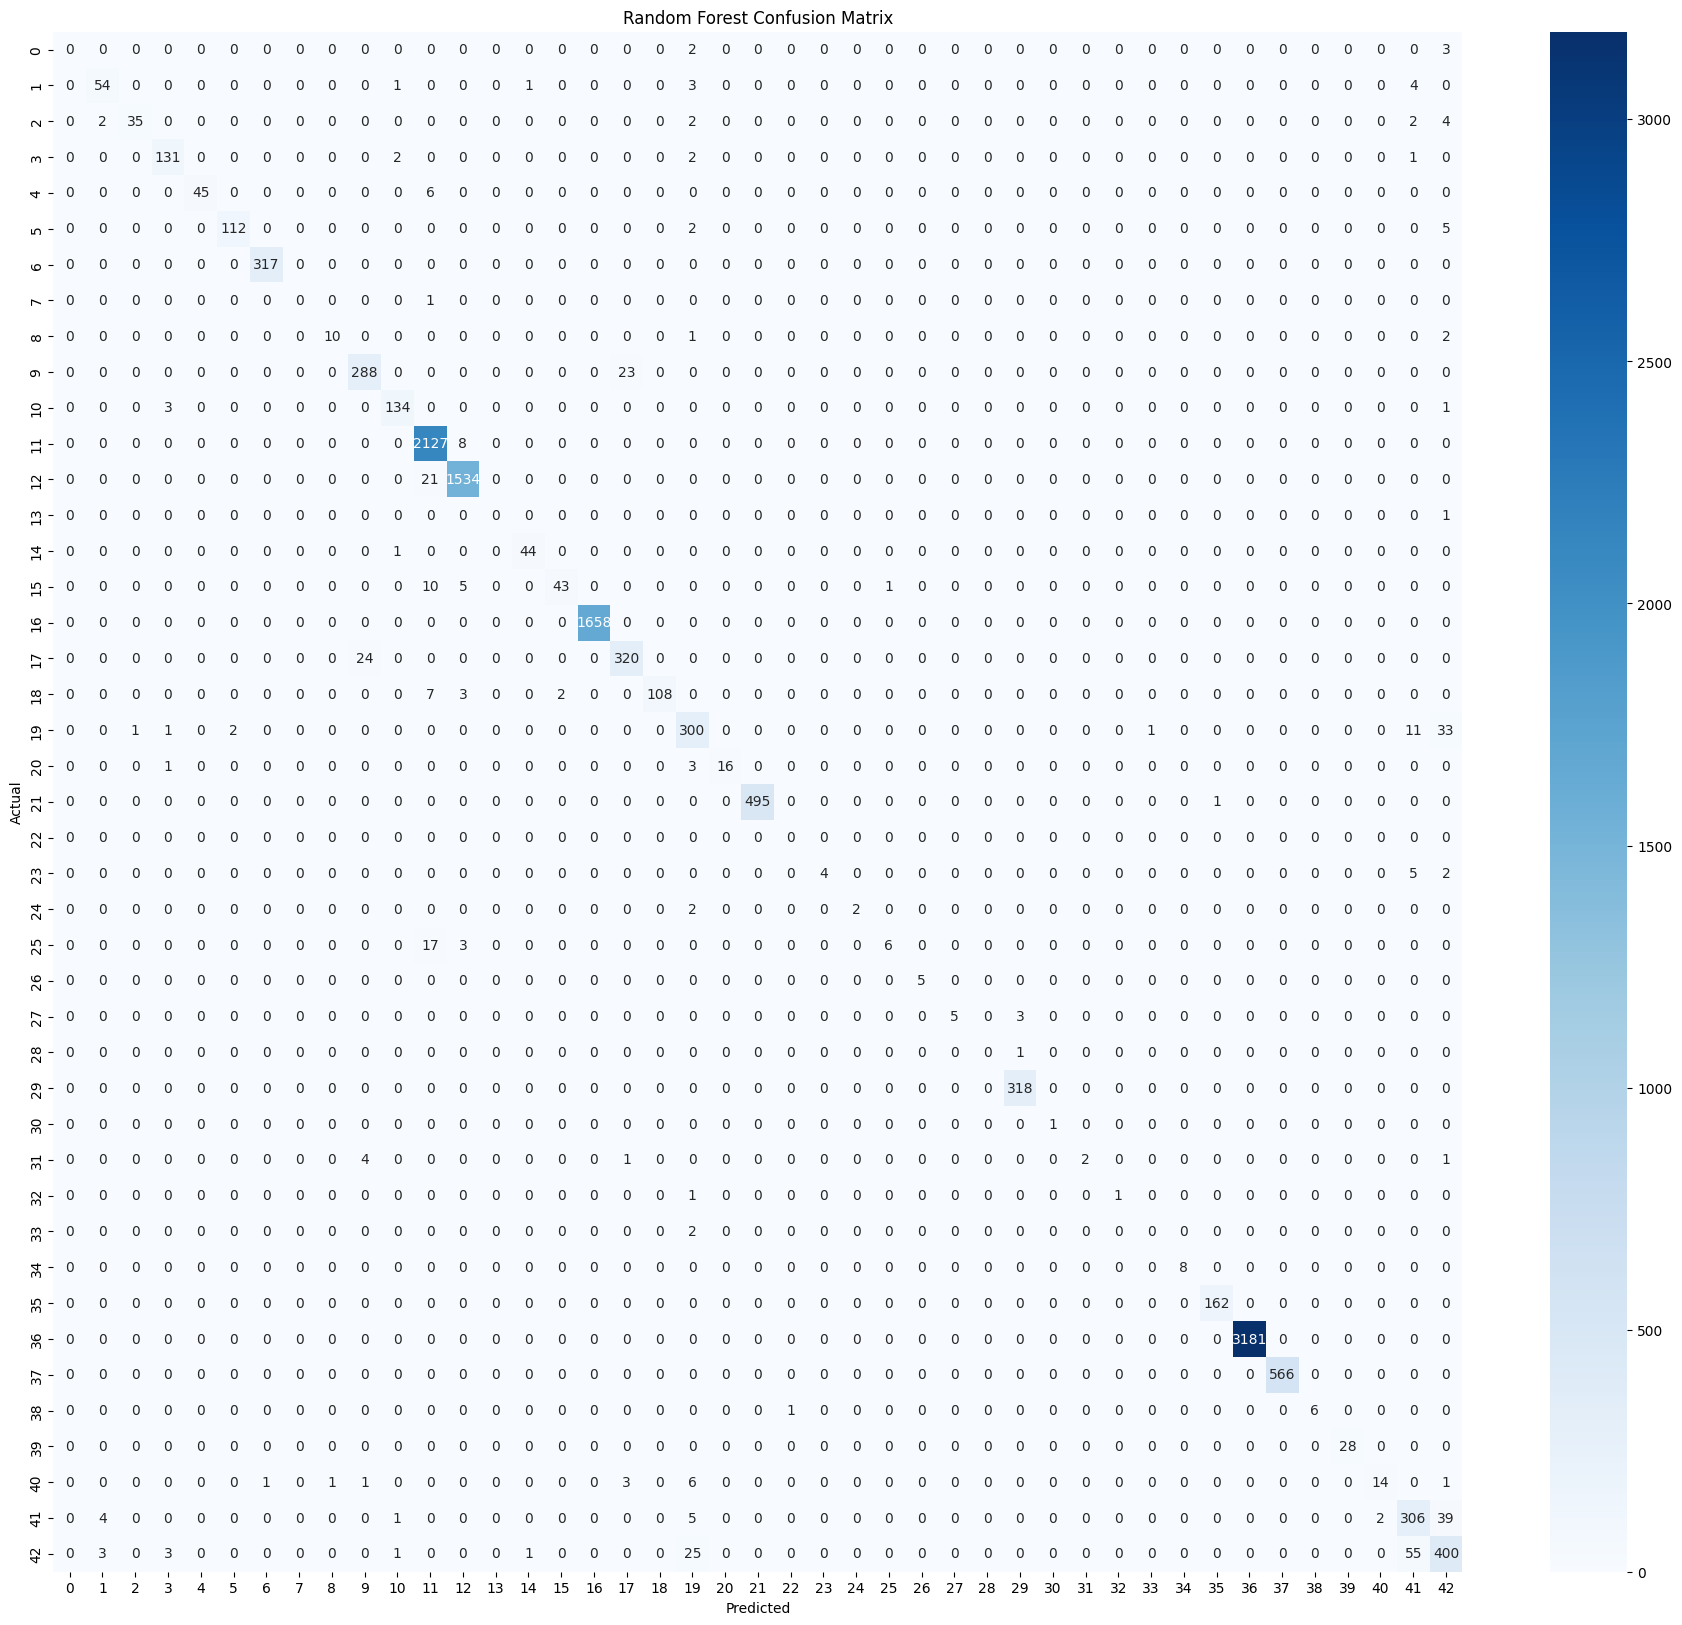

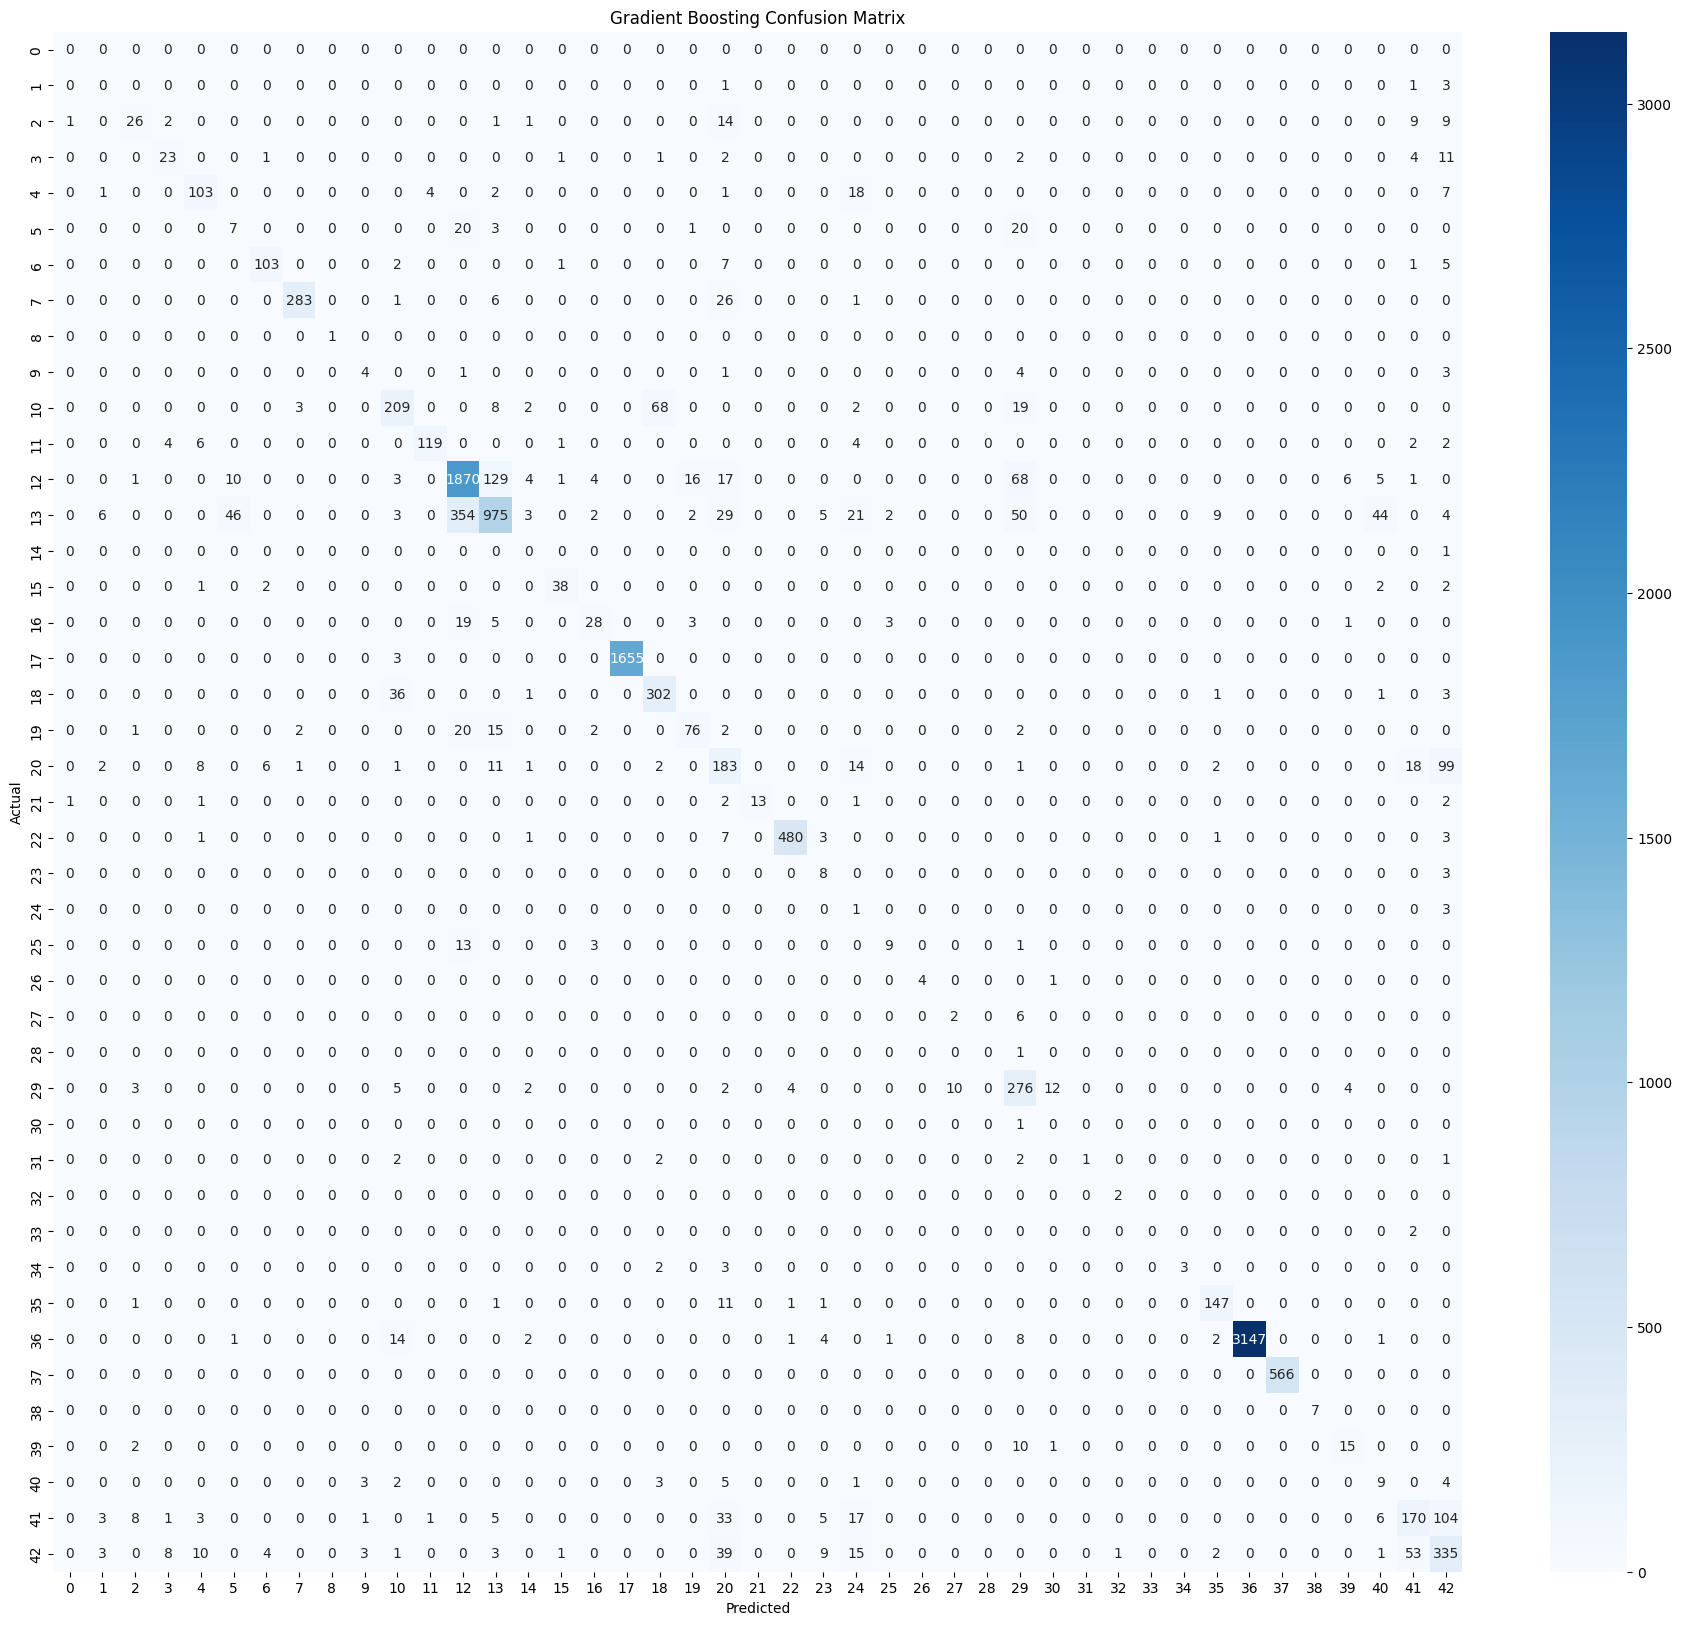

In [18]:
# Results Confusion Matrices

# Random Forest Results Confusion Matrix
plt.figure(figsize = (50, 20))
plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(y_test, rand_for_pred), annot=True, fmt='d', cmap='Blues')
plt.title(f'Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Gradient Boosting Results Confusion Matrix
plt.figure(figsize = (50, 20))
plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(y_test, grad_boost_pred), annot=True, fmt='d', cmap='Blues')
plt.title(f'Gradient Boosting Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

<h3> --------------------------------- Milestone 3 --------------------------------- <h3>

<h4> -------------------------- Final Model Performance Analysis ------------------------<h4>

<p> 
From the Evaluation Metrics of both the Random Forest Classifier and the Gradient Boosting Classifier, one can see that the random forest outperforms the gradient boosting classifier. The accuracy for the random forest was a 96.98% compared the gradient boosting accuracy of 84.91% meaning that the overall correctness of the random forest model is better (keep in mind that accuracy does not measure imalanced classes well). As for Precision, the random forest had a score of 96.94% and the gradient boosting had a score of 84.91%, meaning that the random forest is better than the gradient boosting at minimizing flase positives. As for the recall, the random forest had a score of 96.98% and the gradient boosting had a score of 84.91%, meaning that the random forest captures more postive cases/minimizes false negatives. And as for the F1 score the random forest had a score of 96.87% and the gradient boosting had a score of 85.35%, meaning that the random forest had a better balance between precision and recall than the gradient boosting. Futher, aside from evalutive metrics the random forest classifier took around a minute and a half to fit the model while the gradient boosting took five to 6 minutes to fit the model (this potentially could be becuase i optimized the random forest's hyperparameters with a cv algorithm while i did not do so for the gradient boosting because it was too computationally extensive), meaning that computationally and metrically, the random forest was the superior modeling algorithm for this dataset. Through the utilization of SHAP values, I was able to deduce that critical features like: Magnitude, Begin_Lat, and Begin_lon had the most significant influence on predicting Event_type, provding transparency in feature importance. This translates to, mainly spatial and intensity related attributes having the most pull when dictating the likelihood of the occurence of a storm event. As for the limitations of my model, I believe that, while random forest performs well on this dataset, it might not do as well with generalization and testing on new/unseen data due to its reliance on a subset of specific features and their distributions. Further, since the dataset used was determined to have class imbalances, we can presume that the models high accuracy might be hiding poor performance on minority classes. Then finally, as for areas of improvement, I believe there were two areas that were not properly explored, those being: a lack of gradient boosting cross validation and class imbalance handling. Due to the computational cost of gradient boosting cross validation, I opted to not include it which could have boosted its performance and done potentially better than the random forest. Also, to account for class imbalance I could have used oversampling or cost-sensitive learning techniques to handle it, instead I decided to not do anything about the class imbalance because I believed the tree based algorithms, random forest and gradient boosting, would be able to handle it as they were.
 <p>

In [ ]:
# Helper statements

# shap explainers
explainer_rand_forest = shap.TreeExplainer(rand_search_for)
explainer_grad_boost = shap.TreeExplainer(gradient_boosting)

# Shap Values
shap_rand_forest = explainer_rand_forest(X_test)
shap_grad_boost = explainer_grad_boost(X_test)

# visualizing shap values
shap.summary_plot(shap_rand_forest)
shap.summary_plot(shap_grad_boost)


InvalidModelError: GradientBoostingClassifier is only supported for binary classification right now!

<h5>----- Deployment Plan Description -----<h5>

<p>
The deployment architecutre includes four main components: the model, data pipelines, monitoring systems, and user interfaces. The model, in my case a random forest model, is the central engine that powers the predictions and should be hosted in a scalable environment, like mainly Kubernetes (or alternatively ECS, MicroK8s, RKE, etc...). Data pipelines are in charge or handling data ingestion, preprocessing, and storage in either real-time from steaming sources or in batches. Monitoring systems ensure the model is able to perform reliably over time. They are in charge of evaluative metrics tracking (accuracy, precision, etc...) and also detecting potential data drift using tools like Evidently AI. Finally, user interfaces allow people outside of the development with less technical knowledge to interact with the system through user-friendly GUIs (dashboards, mobile/web applications, etc...). The first step to conduct the mock deployment of our Random Forest model begins with initializing the environment. To do that we have to setup a docker container with all the necessary dependencies such as scikit-learn, pandas, FastAPI so that our model can serve predictions. The Dockerfile is used to package the API application. Then, our model is serialized and loaded within the FastAPI application which exposes endpoints to obtain data and serve predictions. Next, the container is deployed to a scalable could service like AWS ECS or Google Kubernetes. As for the data pipeline, we can integrate something like an Apache Kfaka producer (which would also preprocess input before giving it to the model) to send data streams to the now deployed model. And for monitoring systems, we can use Prometheus to track performance indicators and Evidently AI to detect potential data drift. User interfaces are deployed separately usually and interact with the backend (the model api) through a GUI that makes it easy for non-technical peoples to access models/predictions. Scalability is handled through the use of systems like Kubernetes or AWS ECS as they enable horizontal scaling which manages high traffic efficiently and have Content delivery networks to enhance frontend delivery spped. Maintenance is handled through the integration of CI/CD pipelines like GitHub which allow automated testing and deployment, and allow developers to rollback if ever needed. Compliance with legal regulations (like GDPR or CCPA) is handled through the anonymizing of sensitive user data before processing and incorporating logging ensuring that prediction records are retained securely.
<p>

<p>References: <p>
<p> service documentation <p>
<p> https://dev.to/pavanbelagattia-step-by-step-guide-to-containerizing-and-deploying-machine-learning-models-with-docker-21al<p>
<p>https://www.youtube.com/watch?v=pJ_nCklQ65w<p>
<p>https://medium.com/@ashmi_banerjee/tutorial-serve-a-containerised-ml-model-using-fastapi-and-docker-eaa0d9b05743<p>

<h5>----- Ethical Considerations -----<h5>

<p>
The deployment of a machine learning model that serves to predict weather events or disaster risks has significant potential impact on society depending on the results derived through it. For example, it could improve public safety by giving people the ability to warn the people in the locations of the predicted weather events earlier, which would allow them to prepare for it better and would allow for better/earlier resource allocation by government officials. However, inaccuracies in the predictions could lead to false alarms, public unrest, or unpredicted events which could cost those that allotcated resources to prepare for the predicted storm event and would lead to people garnering distrust in the model. Further, the model could also be subject to developing biases if not properly validated. Bias in the dataset may potentially result in unequal treatment of different groups as was seen in the COMPAS risk assesesment model. For example, the model could end up favoring well-resourced regions over underprivileged regions due to unfound or undealt with bias. As for stakeholder effects, developers of the model would be responsible for ensuring that the model functions correctly and ethically, which would mean that they are responsible for dealing with potential biases in the dataset, maintaining transparency, and monitoring the performance of the model. stakeholders would also have a vested interest in ensuring that the model upholds any governmental laws/regulations (i.e GDPR, CCPA) like ensuring data privacy and accountability, acounting for potential discrimination, etc... Recommendations for ensuring fairness are ensuring regular audits using fairness metrics, like disparate impact or demographic parity. Further, model interpreatation techniques like SHAP can determine if any features contribute to biased prediction results, thus frequent use of validation techniques are critical for ensuring fairness. Recommendations for ensuring accoutability are extensive and frequent use of logging and use of CI/CD pipelines like GitHub. Extensive and frequent use of logging makes it so there is a process for reviewing and addressing errors quickly and efficiently. And through the use of CI/CD pipelines like GitHub, you are able to use version control for models meaning that dvelopers can track changes and rollback if any changes unexpectedly change the model for the worse. Recommendations for ensuring compliance with regulations are ensuring data privacy and user consent. data privacy can be achieved by following the regulations set in place by organizations like GDPR or CCPA, one example of this being anonymizing sensitive data before it is used for training or testing. User consent provides users with clear terms of service and privacy policies which ensures that users understand and agree to the use of their data for whatever purposes are given in the tos or policies.
<p>